In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

170508288/170498071 [==============================] - 3s 0us/step


In [2]:
import tensorflow_addons as tfa

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    angle = tf.random.uniform([], -0.2, 0.2)  # 랜덤 각도 생성
    image = tfa.image.rotate(image, angle)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000,AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2) 
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    ds = ds.repeat() 
    ds = ds.batch(512) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)


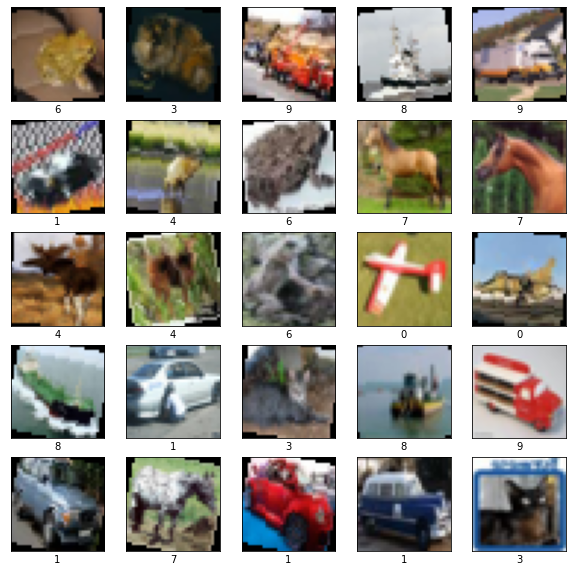

In [3]:
augmented_images, augmented_labels = next(iter(train_ds))

# 이미지를 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_images[i].numpy())
    plt.xlabel(str(augmented_labels[i].numpy()[0]))  # [0]을 추가하여 2D 배열에서 값을 추출합니다.
plt.show()

In [4]:
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [5]:
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

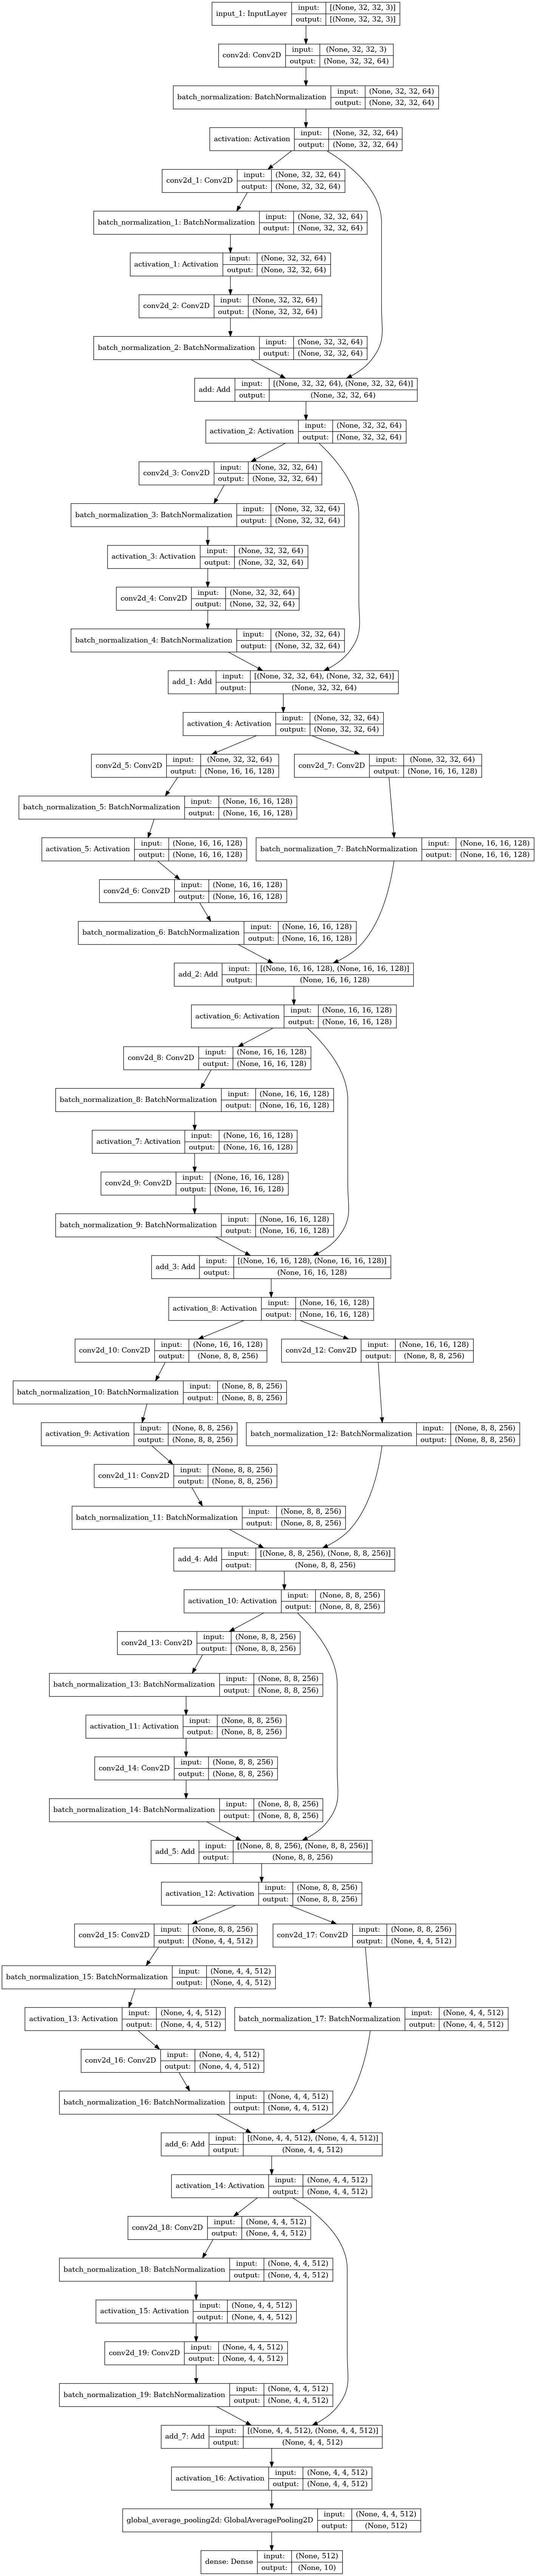

In [6]:
plot_model(model, to_file='resnet18.png', show_shapes=True, show_layer_names=True)

In [7]:
# 학습률 기록 콜백 정의
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nLearning Rate for Epoch {epoch+1}: {self.model.optimizer.lr.numpy()}")

In [8]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# 학습률 스케줄러 정의
def lr_schedule(epoch):
    if epoch < 50:
        lr = 0.001
    elif epoch < 75:
        lr = 0.0005
    else:
        lr = 0.01
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [10]:
# 학습률 기록 콜백 생성
lr_logger = LearningRateLogger()

In [11]:
# 학습 루프
num_epochs = 100

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)

# steps_per_epoch를 설정합니다. 
steps_per_epoch = len(x_train) // 512

# 학습을 수행합니다.
history = model.fit(train_ds, 
                    epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch, 
                    callbacks=[lr_scheduler, lr_logger, early_stop])

Epoch 1/100
97/97 [==============================] - 90s 387ms/step - loss: 1.5425 - accuracy: 0.4557

Learning Rate for Epoch 1: 0.0010000000474974513
Epoch 2/100
97/97 [==============================] - 39s 403ms/step - loss: 1.0229 - accuracy: 0.6370

Learning Rate for Epoch 2: 0.0010000000474974513
Epoch 3/100
97/97 [==============================] - 40s 410ms/step - loss: 0.8073 - accuracy: 0.7144

Learning Rate for Epoch 3: 0.0010000000474974513
Epoch 4/100
97/97 [==============================] - 40s 415ms/step - loss: 0.6715 - accuracy: 0.7640

Learning Rate for Epoch 4: 0.0010000000474974513
Epoch 5/100
97/97 [==============================] - 41s 421ms/step - loss: 0.5778 - accuracy: 0.7985

Learning Rate for Epoch 5: 0.0010000000474974513
Epoch 6/100
97/97 [==============================] - 41s 422ms/step - loss: 0.5104 - accuracy: 0.8213

Learning Rate for Epoch 6: 0.0010000000474974513
Epoch 7/100
97/97 [==============================] - 41s 427ms/step - loss: 0.4625 - acc


Learning Rate for Epoch 52: 0.0005000000237487257
Epoch 53/100
97/97 [==============================] - 43s 441ms/step - loss: 0.0115 - accuracy: 0.9962

Learning Rate for Epoch 53: 0.0005000000237487257
Epoch 54/100
97/97 [==============================] - 43s 441ms/step - loss: 0.0119 - accuracy: 0.9959

Learning Rate for Epoch 54: 0.0005000000237487257
Epoch 55/100
97/97 [==============================] - 43s 441ms/step - loss: 0.0115 - accuracy: 0.9962

Learning Rate for Epoch 55: 0.0005000000237487257
Epoch 56/100
97/97 [==============================] - 43s 441ms/step - loss: 0.0127 - accuracy: 0.9957

Learning Rate for Epoch 56: 0.0005000000237487257
Epoch 57/100
97/97 [==============================] - 43s 441ms/step - loss: 0.0102 - accuracy: 0.9965

Learning Rate for Epoch 57: 0.0005000000237487257
Epoch 58/100
97/97 [==============================] - 43s 441ms/step - loss: 0.0120 - accuracy: 0.9960

Learning Rate for Epoch 58: 0.0005000000237487257
Epoch 59/100
97/97 [=====

In [12]:
#모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")

313/313 - 5s - loss: 0.5484 - accuracy: 0.8921
Test accuracy: 89.21%


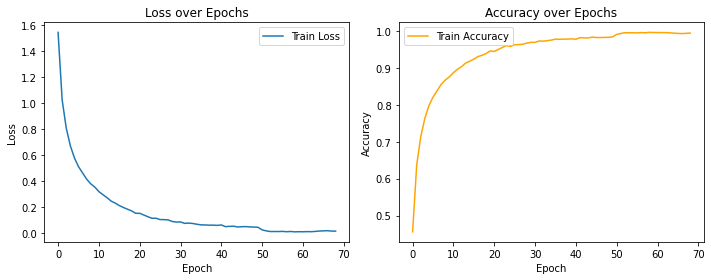

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

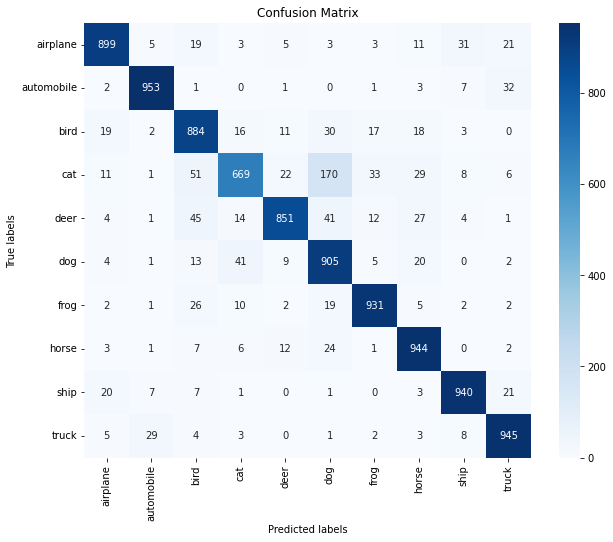

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 모델을 사용하여 예측 수행
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# 컨퓨전 매트릭스 생성
cm = confusion_matrix(y_true, y_pred_classes)

# 컨퓨전 매트릭스 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

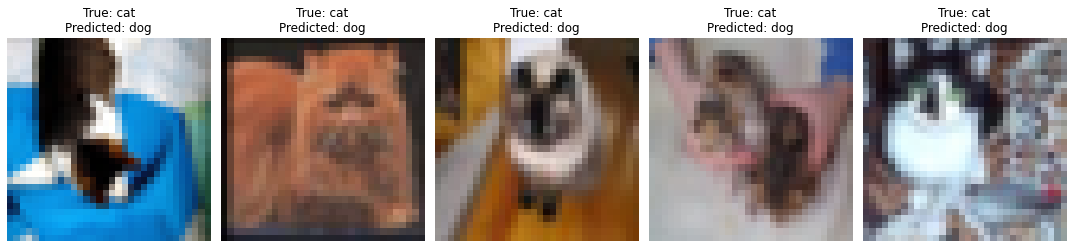

In [15]:
# 모델을 사용하여 예측 수행
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.squeeze()

# "개"를 예측했는데 실제로는 "고양이"인 경우와 "고양이"를 예측했는데 실제로는 "개"인 경우의 인덱스를 찾습니다.
misclassified_as_dog = np.where((y_true == 3) & (y_pred_classes == 5))[0]
misclassified_as_cat = np.where((y_true == 5) & (y_pred_classes == 3))[0]

# 두 경우를 합쳐서 전체 잘못 분류된 인덱스를 얻습니다.
total_misclassified = np.concatenate([misclassified_as_dog, misclassified_as_cat])

# 잘못 분류된 인덱스 중에서 무작위로 5개를 선택합니다.
selected_idx = np.random.choice(total_misclassified, 5, replace=False)

# 시각화
plt.figure(figsize=(15, 5))

for i, idx in enumerate(selected_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx], cmap='gray')  # 'cmap' 파라미터는 필요에 따라 제거할 수 있습니다.
    plt.title(f"True: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

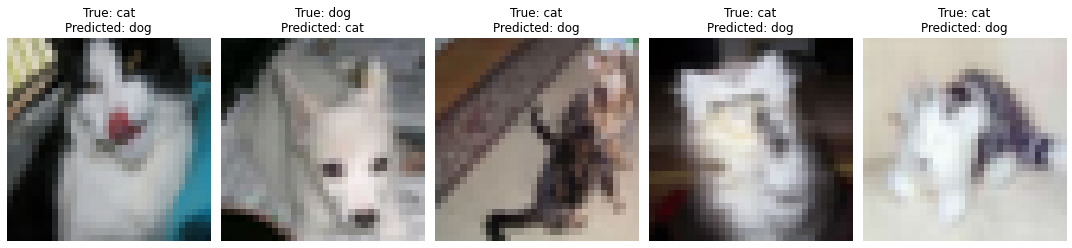

In [16]:
selected_idx = np.random.choice(total_misclassified, 5, replace=False)

# 시각화
plt.figure(figsize=(15, 5))

for i, idx in enumerate(selected_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx], cmap='gray')  # 'cmap' 파라미터는 필요에 따라 제거할 수 있습니다.
    plt.title(f"True: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

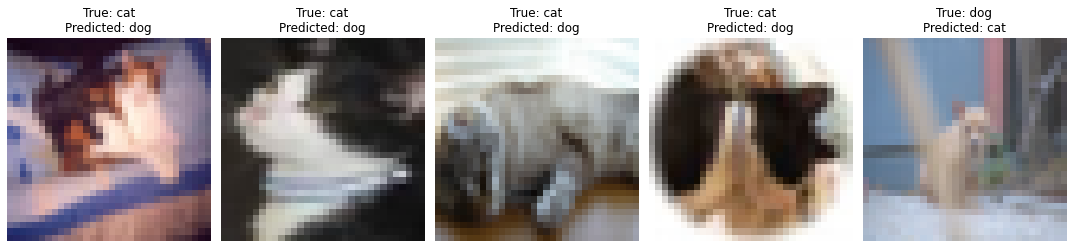

In [17]:
selected_idx = np.random.choice(total_misclassified, 5, replace=False)

# 시각화
plt.figure(figsize=(15, 5))

for i, idx in enumerate(selected_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx], cmap='gray')  # 'cmap' 파라미터는 필요에 따라 제거할 수 있습니다.
    plt.title(f"True: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()